# TODO:
MLP
- Data analysis
- Data preprocessing and normalization
- Data split
- Configuration
- Experiment tracking
- Experiments - meaningful based on the results of previous experiments
    - Including improvement techniques (e.g. Dropout, Normalization layers, Skip
    Connections, Bottleneck Layers, …)
- Hyperparameter search (grid/random) / sweep     #optional
- Results and evaluation metrics
- Clear code
- Markdown documentation and comments
- Final presentation of projects
- Effort on consultations


# OUR TODO:
- download dataset using pandas ? easier because of we can just use link but maybe everyone will use pandas 
- good enough data analysis that is seen in jupyter notebook, not just from reading dataset
- correlation chart  -  chart of correlation of columns between themselves
- outliers - what to do with them ? 
- counts of data in each column and plots of them 

imports

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas as pd

# Dataset

In [15]:


df = pd.read_csv("dataset.csv")

print("Shape of dataset:", df.shape)
display(df.head())

numeric_df = df.select_dtypes(include=["number"])

Shape of dataset: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Data analysis with nice graphs and chart of correlations

In [16]:

# if numeric_df.empty:
#     print("No number attrs for boxplot.")
# else:
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(data=numeric_df, orient="h", palette="Set2")
#     plt.title("Boxplot for all number attributes")
#     plt.xlabel("Values")
#     plt.ylabel("Attributes")
#     plt.tight_layout()
#     plt.show()

df.info()

df.count(numeric_only=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

USMER                   1048575
MEDICAL_UNIT            1048575
SEX                     1048575
PATIENT_TYPE            1048575
INTUBED                 1048575
PNEUMONIA               1048575
AGE                     1048575
PREGNANT                1048575
DIABETES                1048575
COPD                    1048575
ASTHMA                  1048575
INMSUPR                 1048575
HIPERTENSION            1048575
OTHER_DISEASE           1048575
CARDIOVASCULAR          1048575
OBESITY                 1048575
RENAL_CHRONIC           1048575
TOBACCO                 1048575
CLASIFFICATION_FINAL    1048575
ICU                     1048575
dtype: int64

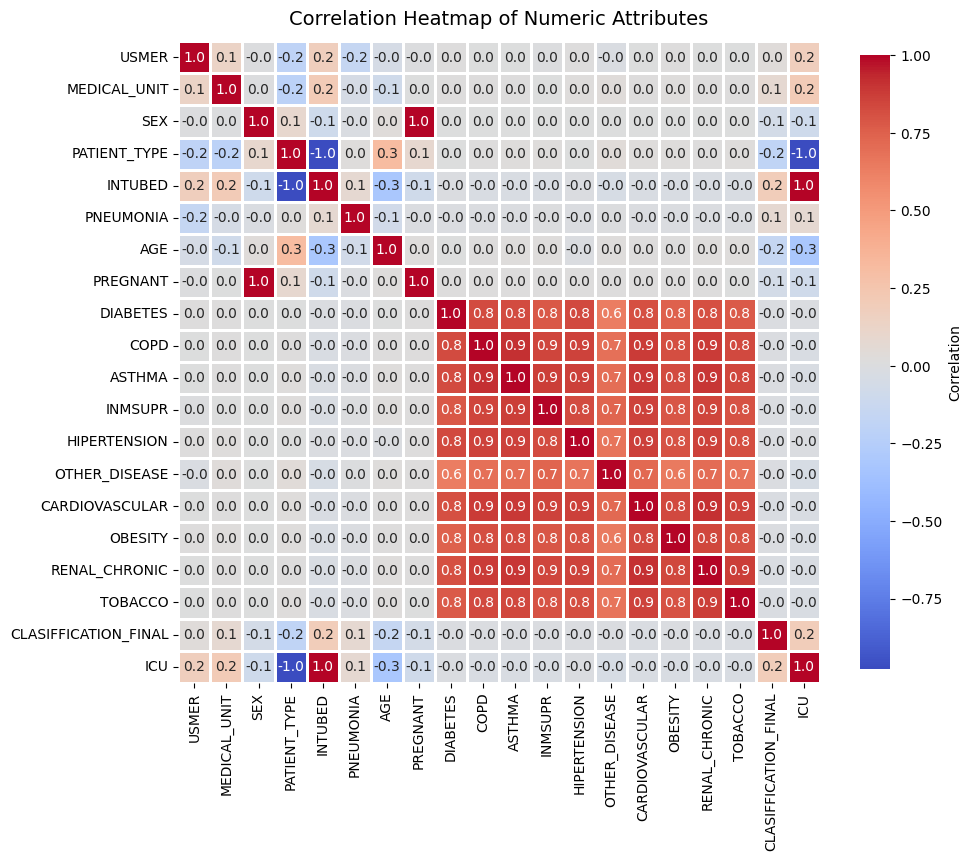

In [17]:

corr = numeric_df.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(
    corr,
    annot=True,         # Show correlation values
    cmap="coolwarm",    # Color palette
    fmt=".1f",          # Format numbers to 1
    square=True,        # Make cells square
    linewidths=1,     # Add thin lines between cells
    cbar_kws={"shrink": 0.7, "label": "Correlation"}
)

plt.title("Correlation Heatmap of Numeric Attributes", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# Data preprocessing and normalization

## Probably normalize like this: 
    - date_died change from date and 9999-99-99 with 1-died 0-alive ?? maybe
    - pregnant men don't exist, either leave 97 as NA for column pregnant for men or normalize and set it to 0